## DE analysis - explore outputs

In [1]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sc_target_evidence_utils import preprocessing_utils

In [2]:
### Make diagnostic plots ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import anndata

import obonet

obo_file = "/nfs/team205/ed6/bin/sc_target_evidence/data/cl.obo"  # downloaded from http://obofoundry.org/ontology/cl.html

# Load the ontology from the OBO file
graph = obonet.read_obo(obo_file)

def ontology2name(o):
    return(graph.nodes.get(o)['name'])

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [99]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/DE_exploratory_plots/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [6]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

In [7]:
disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [8]:
def volcano_plot(
    de_res,     
    nrows = 3,
    ncols = 4,
    alpha=0.1,
    savefig = None
):
    disease_res_all = de_res.copy()
    disease_res_all.loc[disease_res_all.lfc > 10, 'lfc'] = 10
    disease_res_all.loc[disease_res_all.lfc < -10, 'lfc'] = -10

    disease_res_all['log_adj_pval'] = - np.log10(disease_res_all['adj_pval'])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 11))

    for i, ct in enumerate(disease_res_all.high_level_cell_type_ontology_term_id.unique().tolist()):
        row_i, col_i = divmod(i, ncols)  # Calculate the row and column indices

        ax = axes[row_i, col_i]  # Get the corresponding subplot axis

        sns.scatterplot(data=disease_res_all[disease_res_all.high_level_cell_type_ontology_term_id == ct],
                        s=3, color='grey',
                        x='lfc', y='log_adj_pval', ax=ax)
        ax.set_title(ct.replace(" (CL:", "\n(CL:"))
        ax.axvline(0, color='r', linewidth=1, linestyle='--')
        ax.axhline( - np.log10(alpha), color='r', linewidth=1, linestyle='--')

    fig.tight_layout()  # Adjust subplot spacing
    if savefig:
        fig.savefig(savefig)
    
    fig.show()

In [9]:
def plot_ecdf(data, label=None, color='black'):
    # Sort the data in ascending order
    data_sorted = np.sort(data)

    # Calculate ECDF
    n = len(data_sorted)
    x = np.sort(data_sorted)
    y = np.arange(1, n + 1) / n

    # Plot the ECDF
    plt.plot(x, y, label=label, color=color)
    plt.ylabel('ECDF')
    plt.margins(0.02)  # Add a little space to the plot

    
def plot_ncelltypes_lfc(
    disease_res,
    sc_evidence,
    signif_thresh = 0.1,
    lfc_thresh = 0):
    n_cell_types = disease_res.high_level_cell_type_ontology_term_id.nunique()
#     merged_disease_res = pd.merge(disease_res, OT_targets_df[OT_targets_df['disease_ontology_id'] == disease_ontology_id])
    merged_disease_res = disease_res.copy()

    lfc_thresh_values = [0, 0.1, 1, 2, 3, 4, 5]
    cmap = matplotlib.colors.ListedColormap(plt.cm.viridis(np.linspace(0, 1, len(lfc_thresh_values))))

    for i, lfc_thresh in enumerate(lfc_thresh_values): 
        if sc_evidence == 'diseasecelltype':
            merged_disease_res['is_signif'] = (merged_disease_res['adj_pval'] < signif_thresh) & (np.abs(merged_disease_res['lfc']) > lfc_thresh)
        else:
            merged_disease_res['is_signif'] = (merged_disease_res['adj_pval'] < signif_thresh) & ((merged_disease_res['lfc']) > lfc_thresh)

        n_signif_cts = merged_disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
        plot_ecdf(n_signif_cts, label = f'LFC thresh = {lfc_thresh}', color=cmap(i));
        plt.legend();
        plt.xlabel(f'# signif cell types\n(total = {n_cell_types})')

In [11]:
disease_name_mapper

{'PATO:0000461': 'normal',
 'MONDO:0007254': 'breast cancer',
 'MONDO:0002771': 'pulmonary fibrosis',
 'MONDO:0005097': 'squamous cell lung carcinoma',
 'MONDO:0005061': 'lung adenocarcinoma',
 'MONDO:0005249': 'pneumonia',
 'MONDO:0100096': 'COVID-19',
 'MONDO:0009061': 'cystic fibrosis',
 'MONDO:0004514': 'chronic rhinitis',
 'MONDO:0015925': 'interstitial lung disease',
 'MONDO:0005233': 'non-small cell lung carcinoma',
 'MONDO:0001627': 'dementia',
 'MONDO:0005011': 'Crohn disease',
 'MONDO:0016691': 'pilocytic astrocytoma',
 'MONDO:0004298': 'stomach disorder',
 'MONDO:0001056': 'gastric cancer',
 'MONDO:0004966': 'gastritis',
 'MONDO:0013662': 'Barrett esophagus',
 'MONDO:0015517': 'common variable immunodeficiency',
 'MONDO:0004849': 'pulmonary emphysema',
 'MONDO:0024885': 'malignant ovarian serous tumor',
 'MONDO:0024660': 'tubular adenoma',
 'MONDO:0006156': 'colon sessile serrated adenoma/polyp',
 'MONDO:0024661': 'tubulovillous adenoma',
 'MONDO:0006249': 'hyperplastic poly

In [12]:
## Get all disease IDs
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]

In [69]:
disease_ontology_id = 'MONDO_0005061'
ev = 'celltype'
de_res = pd.read_csv(f'{data_dir}/DE_{ev}_{disease_ontology_id.replace(":","_")}.hvgs.csv')

In [70]:
plot_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/plots/'

disease_name = disease_name_mapper[disease_ontology_id.replace("_", ":")]
plot_dir = plot_dir + f'/{disease_ontology_id.replace(":", "_")}_{preprocessing_utils.clean_disease_name(disease_name)}/'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

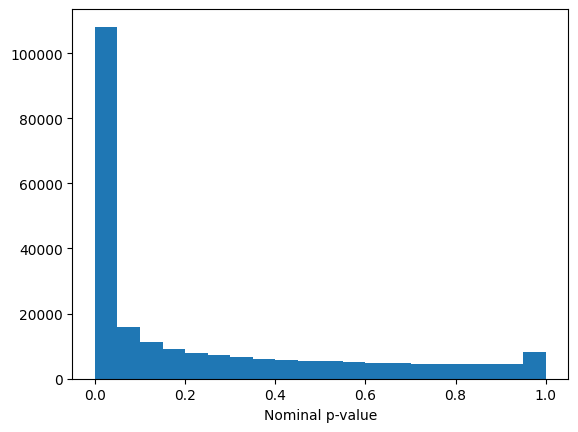

In [71]:
## P-value histogram
plt.hist(de_res.pval, bins=20);
plt.xlabel('Nominal p-value');
plt.savefig(plot_dir + f'/DE_{ev}.pval_hist.png')

/tmp/ipykernel_8415/2290542545.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()  # Adjust subplot spacing


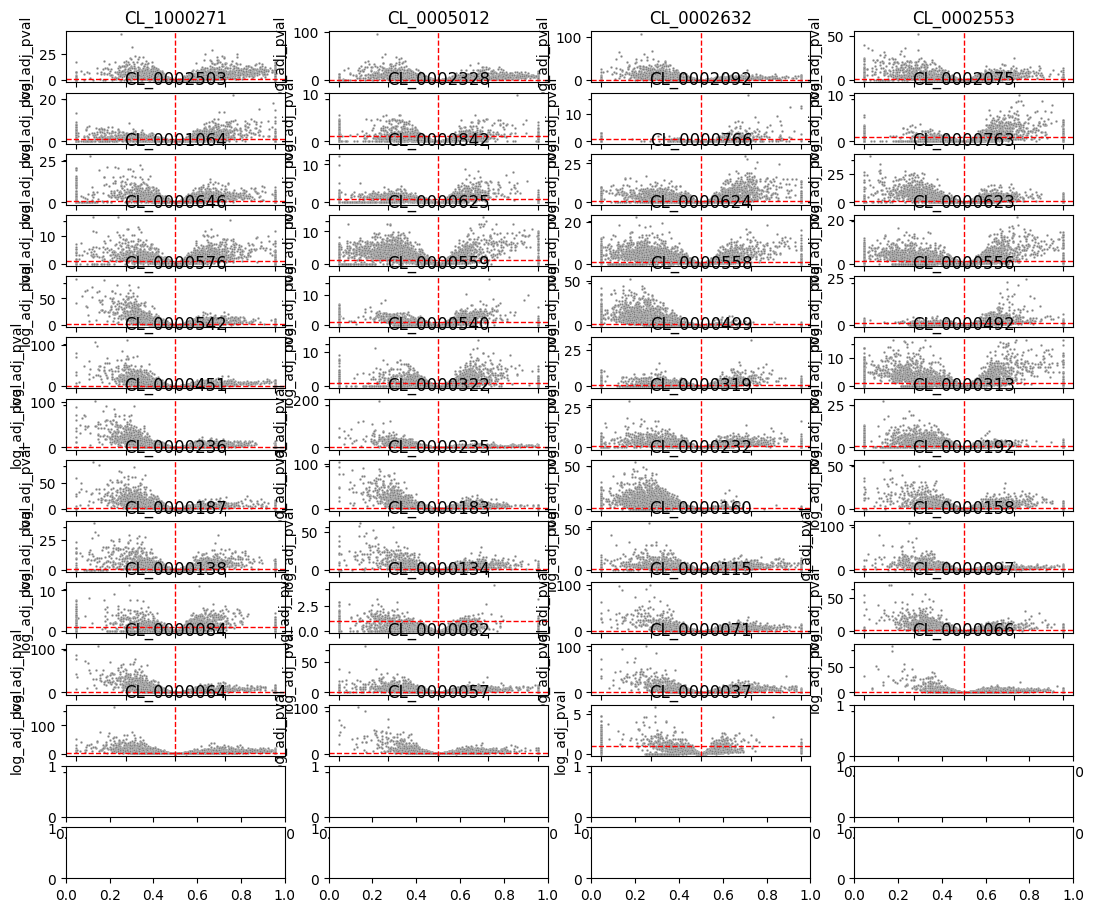

In [72]:
## Plot volcano
n_cts = de_res.high_level_cell_type_ontology_term_id.nunique()
n_cols=4
volcano_plot(de_res,
             alpha=0.1,
             ncols=n_cols, nrows=int(np.round(n_cts / n_cols) + 2),
             savefig = plot_dir + f'/DE_{ev}.volcano.png'
            );

/tmp/ipykernel_8415/1654654832.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = merged_disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_8415/1654654832.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = merged_disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_8415/1654654832.py:34: FutureWarning: The default value of numeric_only in Da

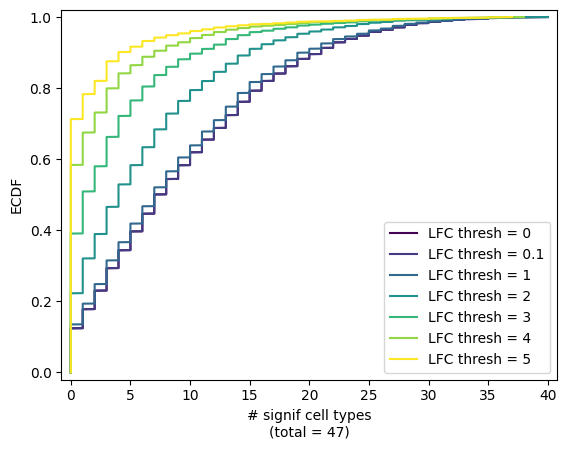

In [73]:
plot_ncelltypes_lfc(de_res, sc_evidence=ev)

### Show different specificity for different logFC threshold

In [74]:
pbulk_adata = sc.read_h5ad(f'{data_dir}/cellxgene_targets_{disease_ontology_id}.pbulk_all_genes.h5ad')

## Preprocess expression
cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

In [132]:
sns.set_context('paper')
n_signif = 5
n_cts = 10

if n_cts is not None:
    plot_cts = de_res.high_level_cell_type_ontology_term_id.drop_duplicates().sample(n_cts).values
else:
    plot_cts = de_res.high_level_cell_type_ontology_term_id.drop_duplicates().values

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


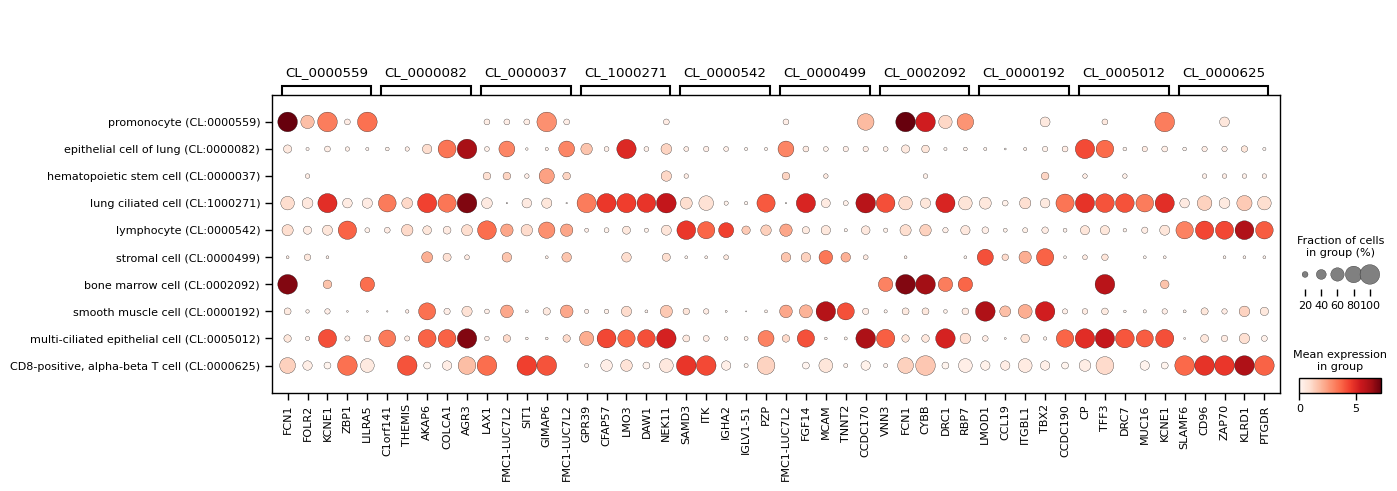

In [133]:
# Get significant pairs for each cell type
min_lfc = 5
max_lfc = 100
signif_df_res = de_res[(de_res['adj_pval'] < 0.1) & (de_res['lfc'] > min_lfc) & (de_res['lfc'] < max_lfc)].copy()
dotplot_dict = {}

for ct in plot_cts:
    dotplot_dict[ct] = signif_df_res[signif_df_res.high_level_cell_type_ontology_term_id == ct].gene_name.tolist()
    if n_signif is not None:
        dotplot_dict[ct] = np.random.choice(dotplot_dict[ct], n_signif)

pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_')
missing_cts = [x for x in pbulk_adata.obs['plot_ct_id'].unique() if x not in dotplot_dict.keys()]
pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category').cat.reorder_categories(list(dotplot_dict.keys()) + missing_cts)
ct_levels = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)

with plt.rc_context({'figure.figsize':[14,5]}):
    fig,axs = plt.subplots(1,1)
    sc.pl.dotplot(
        pbulk_adata[(pbulk_adata.obs['disease'] == 'normal') & (pbulk_adata.obs['plot_ct_id'].isin(dotplot_dict.keys()))], 
        dotplot_dict, 
        groupby='high_level_cell_type', 
        gene_symbols='feature_name',
        layer='logcounts', var_group_rotation=0,
        swap_axes=False,
        show=False, ax=axs
    );
    fig.tight_layout()
    fig.savefig(figdir + "markers_high_logFC.pdf")

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


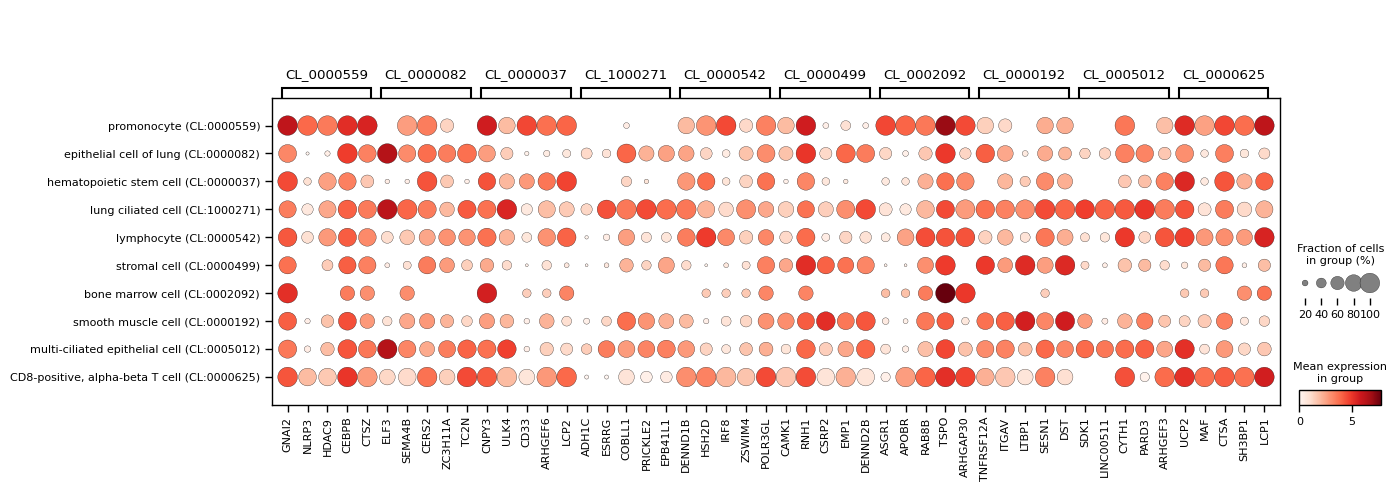

In [136]:
# Get significant pairs for each cell type
min_lfc = 0.5
max_lfc = 5
signif_df_res = de_res[(de_res['adj_pval'] < 0.1) & (de_res['lfc'] > min_lfc) & (de_res['lfc'] < max_lfc)].copy()
dotplot_dict = {}

for ct in plot_cts:
    dotplot_dict[ct] = signif_df_res[signif_df_res.high_level_cell_type_ontology_term_id == ct].gene_name.tolist()
    if n_signif is not None:
        dotplot_dict[ct] = np.random.choice(dotplot_dict[ct], n_signif)

pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_')
missing_cts = [x for x in pbulk_adata.obs['plot_ct_id'].unique() if x not in dotplot_dict.keys()]
pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category').cat.reorder_categories(list(dotplot_dict.keys()) + missing_cts)
ct_levels = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)

with plt.rc_context({'figure.figsize':[14,5]}):
    fig,axs = plt.subplots(1,1)
    sc.pl.dotplot(
        pbulk_adata[(pbulk_adata.obs['disease'] == 'normal') & (pbulk_adata.obs['plot_ct_id'].isin(dotplot_dict.keys()))], 
        dotplot_dict, 
        groupby='high_level_cell_type', 
        gene_symbols='feature_name',
        layer='logcounts', var_group_rotation=0,
        swap_axes=False,
        show=False, ax=axs
    );
    fig.tight_layout()
    fig.savefig(figdir + "markers_low_logFC.pdf")

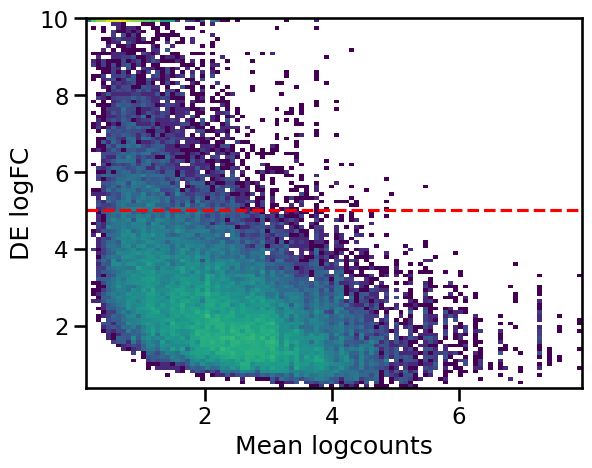

In [137]:
mean_df = pbulk_adata.var[['mean_logcounts']]
mean_df.index.name = 'gene_id'
mean_df.reset_index(inplace=True)

sns.set_context("talk");
de_res_mean = pd.merge(de_res, mean_df, how='left')
de_res_mean.loc[de_res_mean.lfc > 10, 'lfc'] = 10
de_res_mean.loc[de_res_mean.lfc < -10, 'lfc'] = -10
de_res_mean = de_res_mean[de_res_mean.lfc > 0].copy()
plt.hist2d(de_res_mean[de_res_mean.adj_pval < 0.1].mean_logcounts, de_res_mean[de_res_mean.adj_pval < 0.1].lfc, bins=100, norm=matplotlib.colors.LogNorm());
# cbar = plt.colorbar()
# cbar.set_label('# genes')
plt.xlabel('Mean logcounts');
plt.ylabel('DE logFC');
plt.axhline(5, color='red', linestyle='--');
plt.savefig(figdir + 'mean_logcoutns_vs_DElogFC.pdf', bbox_inches='tight')


### Plot disease-specific genes

In [220]:
disease_ontology_id = 'MONDO_0005061'
ev = 'diseasecelltype'
de_res = pd.read_csv(f'{data_dir}/DE_{ev}_{disease_ontology_id.replace(":","_")}.hvgs.csv')
bulk_de_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

In [230]:
de_res['bulk_signif'] = de_res.gene_id.isin(bulk_de_res[bulk_de_res.adj_pval < 0.1].gene_id)

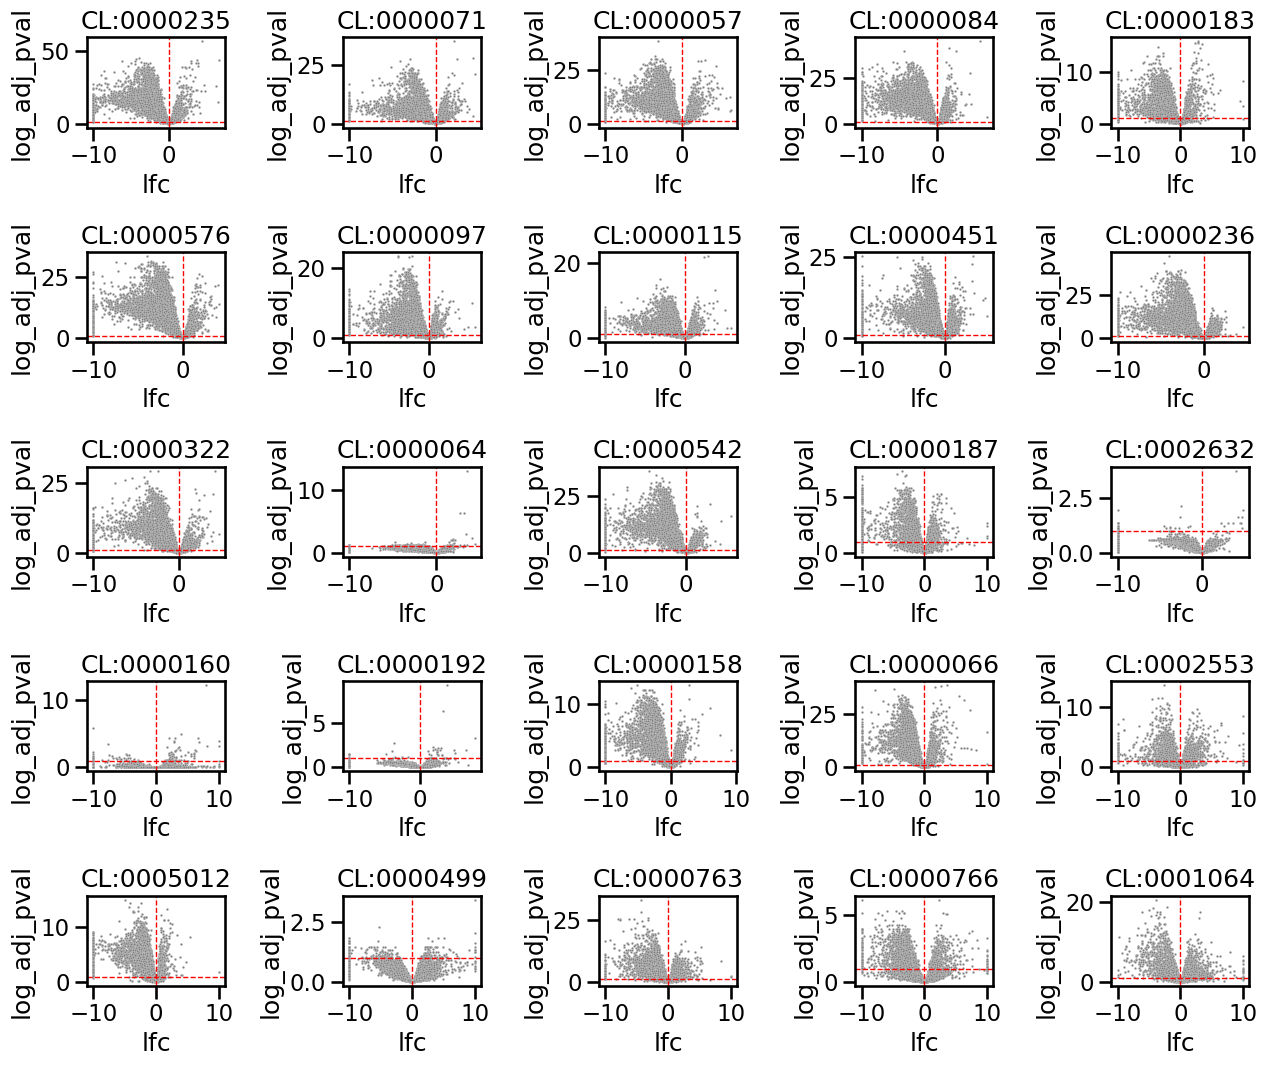

In [146]:
volcano_plot(de_res, ncols=5, nrows=5)

In [213]:
sns.set_context('paper')
n_signif = 5
n_cts = 10

if n_cts is not None:
    plot_cts = de_res.high_level_cell_type_ontology_term_id.drop_duplicates().sample(n_cts).values
else:
    plot_cts = de_res.high_level_cell_type_ontology_term_id.drop_duplicates().values

In [214]:
# Get significant pairs for each cell type
min_lfc = 1.0
max_lfc = 100
signif_df_res = de_res[(de_res['adj_pval'] < 0.1) & (np.abs(de_res['lfc']) > min_lfc) & (np.abs(de_res['lfc']) < max_lfc)].copy()
dotplot_dict = {}

for ct in plot_cts:
    dotplot_dict[ct] = signif_df_res[signif_df_res.high_level_cell_type_ontology_term_id == ct].gene_name.tolist()
    if n_signif is not None:
        dotplot_dict[ct] = np.random.choice(dotplot_dict[ct], n_signif)

pbulk_adata.obs['ct_disease_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].str.replace(":", '_') + "_" + pbulk_adata.obs['disease'].astype('str')
pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['high_level_cell_type_ontology_term_id'].values
missing_cts = [x for x in pbulk_adata.obs['plot_ct_id'].unique() if x not in dotplot_dict.keys()]
pbulk_adata.obs['plot_ct_id'] = pbulk_adata.obs['plot_ct_id'].astype('category').cat.reorder_categories(list(dotplot_dict.keys()) + missing_cts)
ct_levels = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].cat.categories.str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['plot_ct_id'].str.replace("_", ":").tolist()]
pbulk_adata.obs['high_level_cell_type'] = pbulk_adata.obs['high_level_cell_type'].astype('category').cat.reorder_categories(ct_levels)
ct_disease_levels = pbulk_adata.obs[['high_level_cell_type', 'ct_disease_id']].drop_duplicates().sort_values(['high_level_cell_type', 'ct_disease_id']).ct_disease_id.values
pbulk_adata.obs['ct_disease_id'] = pbulk_adata.obs['ct_disease_id'].astype('category').cat.reorder_categories(ct_disease_levels)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


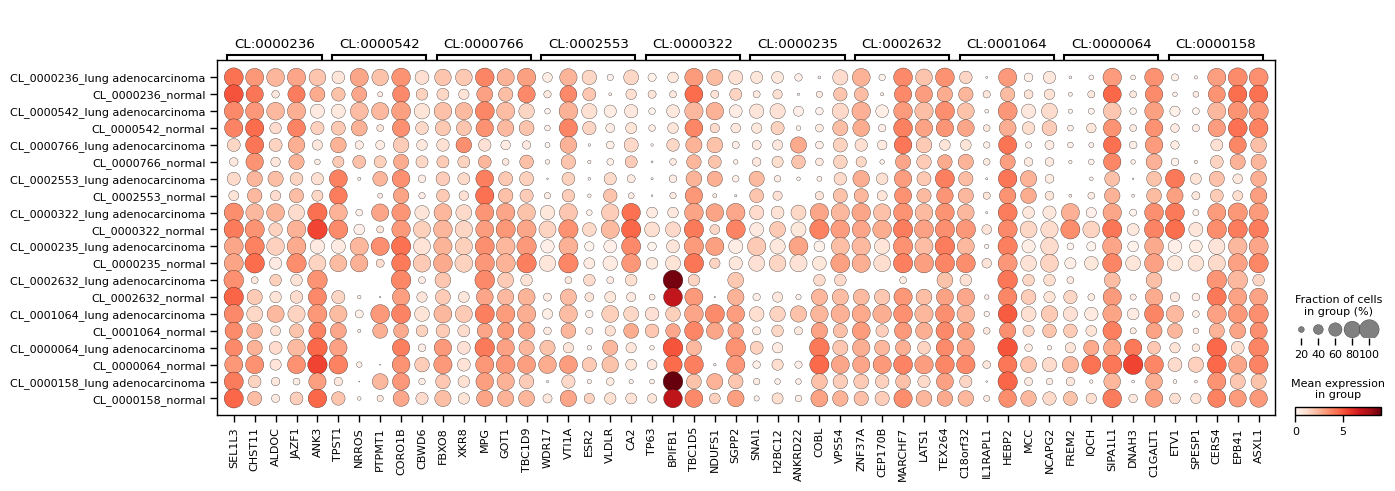

In [215]:
with plt.rc_context({'figure.figsize':[14,5]}):
    fig,axs = plt.subplots(1,1)
    sc.pl.dotplot(
        pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'].isin(plot_cts)], 
        dotplot_dict, 
        groupby='ct_disease_id', 
        gene_symbols='feature_name',
        layer='logcounts', var_group_rotation=0,
        swap_axes=False,
        show=False, ax=axs
    );
    fig.tight_layout()
    fig.show()
#     fig.savefig(figdir + "markers_high_logFC.pdf")

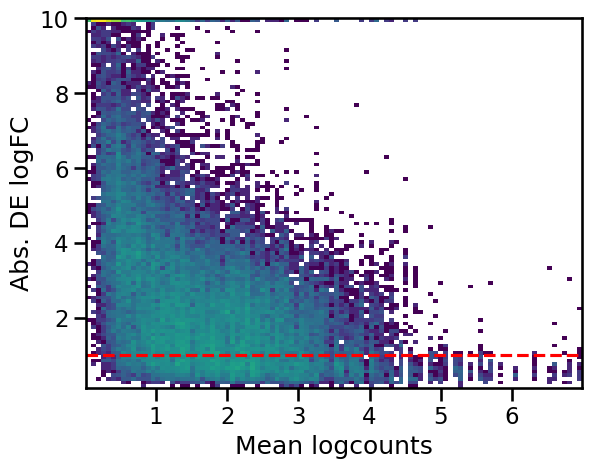

In [234]:
mean_df = pbulk_adata.var[['mean_logcounts']]
mean_df.index.name = 'gene_id'
mean_df.reset_index(inplace=True)

sns.set_context("talk");
de_res_mean = pd.merge(de_res, mean_df, how='left')
de_res_mean.loc[de_res_mean.lfc > 10, 'lfc'] = 10
de_res_mean.loc[de_res_mean.lfc < -10, 'lfc'] = -10

de_res_mean = de_res_mean[de_res_mean.bulk_signif].copy()
plt.hist2d(de_res_mean[de_res_mean.adj_pval < 0.1].mean_logcounts, np.abs(de_res_mean[de_res_mean.adj_pval < 0.1].lfc), bins=100, norm=matplotlib.colors.LogNorm());
# cbar = plt.colorbar()
# cbar.set_label('# genes')
plt.xlabel('Mean logcounts');
plt.ylabel('Abs. DE logFC');
plt.axhline(1.0, color='red', linestyle='--');
plt.savefig(figdir + 'mean_logcoutns_vs_DElogFC_disease.pdf', bbox_inches='tight')


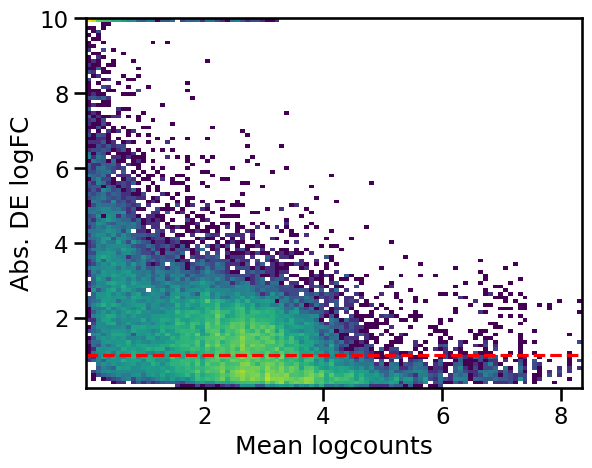

In [235]:
sns.set_context("talk");
de_res_mean = pd.merge(de_res, mean_df, how='left')
de_res_mean.loc[de_res_mean.lfc > 10, 'lfc'] = 10
de_res_mean.loc[de_res_mean.lfc < -10, 'lfc'] = -10

de_res_mean = de_res_mean[~de_res_mean.bulk_signif].copy()
plt.hist2d(de_res_mean[de_res_mean.adj_pval < 0.1].mean_logcounts, np.abs(de_res_mean[de_res_mean.adj_pval < 0.1].lfc), bins=100, norm=matplotlib.colors.LogNorm());
# cbar = plt.colorbar()
# cbar.set_label('# genes')
plt.xlabel('Mean logcounts');
plt.ylabel('Abs. DE logFC');
plt.axhline(1.0, color='red', linestyle='--');
plt.savefig(figdir + 'mean_logcoutns_vs_DElogFC_disease.pdf', bbox_inches='tight')


<AxesSubplot: xlabel='bulk_signif', ylabel='mean_logcounts'>

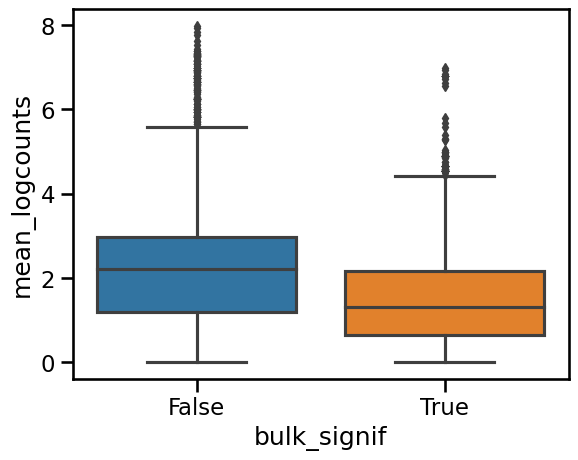

In [242]:
de_res_mean = pd.merge(de_res, mean_df, how='left')
de_res_mean.loc[de_res_mean.lfc > 10, 'lfc'] = 10
de_res_mean.loc[de_res_mean.lfc < -10, 'lfc'] = -10
sns.boxplot(x=de_res_mean[(de_res_mean.adj_pval < 0.1) & (de_res_mean.lfc < 0)].bulk_signif, y=de_res_mean[(de_res_mean.adj_pval < 0.1) & (de_res_mean.lfc < 0)].mean_logcounts) 

Info to add:
- no. of significant cell types per gene
- mean expression per gene

In [77]:
disease_ontology_id = 'MONDO_0009061'
sc_evidence = 'celltype'

disease_res = pd.read_csv(f'{data_dir}/DE_{sc_evidence}_{disease_ontology_id}.all_targets.csv')
pbulk_adata = sc.read_h5ad(f'{data_dir}/cellxgene_targets_{disease_ontology_id}.pbulk_all_OT_targets.h5ad')
pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'] != 'low_quality_annotation'].copy()

## Preprocess expression
cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]

pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

In [132]:
signif_thresh = 0.1

In [153]:
lfcs = [0, 0.5, 1, 2.0, 3.0, 4.0]
disease_res = de_res.copy()
sc_evidence='celltype'

with plt.rc_context({'figure.figsize':[18,4]}):
    for i,lfc_thresh in enumerate(lfcs[0:3]):
        n_cell_types = disease_res.high_level_cell_type_ontology_term_id.nunique()
        if sc_evidence == 'diseasecelltype':
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & (np.abs(disease_res['lfc']) > lfc_thresh)
        else:
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & ((disease_res['lfc']) > lfc_thresh)

        n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
        n_signif_cts = n_signif_cts.reset_index()
        n_signif_cts.columns = ['gene_id', 'n_signif_cts']
    #     disease_res = pd.merge(disease_res, n_signif_cts)
        pbulk_adata.var['n_signif_cts'] = n_signif_cts.set_index('gene_id').loc[pbulk_adata.var_names]

        plt.subplot(1, 3,i+1)
        sns.boxplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', sym='')
        sns.stripplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', size=2, color='black')
        plt.xlabel('# significant cell types');
        plt.ylabel('Mean gene log-counts');
        plt.xlim(0,25);
        r2, pval = scipy.stats.pearsonr(pbulk_adata.var['mean_logcounts'], pbulk_adata.var['n_signif_cts'])
        plt.title(f"LogFC threshold = {lfc_thresh} \nR2 = {np.round(r2, 3)}, p-val = {pval:.2e})")
    
    plt.show()
    
    for i,lfc_thresh in enumerate(lfcs[3:]):
        n_cell_types = disease_res.high_level_cell_type_ontology_term_id.nunique()
        if sc_evidence == 'diseasecelltype':
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & (np.abs(disease_res['lfc']) > lfc_thresh)
        else:
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & ((disease_res['lfc']) > lfc_thresh)

        n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
        n_signif_cts = n_signif_cts.reset_index()
        n_signif_cts.columns = ['gene_id', 'n_signif_cts']
    #     disease_res = pd.merge(disease_res, n_signif_cts)
        pbulk_adata.var['n_signif_cts'] = n_signif_cts.set_index('gene_id').loc[pbulk_adata.var_names]

        plt.subplot(1, 3,i+1)
        sns.boxplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', sym='')
        sns.stripplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', size=2, color='black')
        plt.xlabel('# significant cell types');
        plt.ylabel('Mean gene log-counts');
        plt.xlim(0,25);
        r2, pval = scipy.stats.pearsonr(pbulk_adata.var['mean_logcounts'], pbulk_adata.var['n_signif_cts'])
        plt.title(f"LogFC threshold = {lfc_thresh} \nR2 = {np.round(r2, 3)}, p-val = {pval:.2e})")
        


/tmp/ipykernel_8236/2995474056.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')


KeyError: "['ENSG00000067606', 'ENSG00000157873', 'ENSG00000198793', 'ENSG00000177000', 'ENSG00000120949', 'ENSG00000132906', 'ENSG00000117713', 'ENSG00000116954', 'ENSG00000168653', 'ENSG00000162607', 'ENSG00000162434', 'ENSG00000142867', 'ENSG00000168509', 'ENSG00000143401', 'ENSG00000143384', 'ENSG00000185499', 'ENSG00000163518', 'ENSG00000132693', 'ENSG00000158864', 'ENSG00000162761', 'ENSG00000121454', 'ENSG00000244414', 'ENSG00000143355', 'ENSG00000143486', 'ENSG00000117335', 'ENSG00000143799', 'ENSG00000198626', 'ENSG00000151360', 'ENSG00000176887', 'ENSG00000134323', 'ENSG00000119772', 'ENSG00000171094', 'ENSG00000095002', 'ENSG00000082898', 'ENSG00000173163', 'ENSG00000116001', 'ENSG00000132305', 'ENSG00000169679', 'ENSG00000074047', 'ENSG00000115159', 'ENSG00000003402', 'ENSG00000023228', 'ENSG00000178568', 'ENSG00000068024', 'ENSG00000130414', 'ENSG00000113851', 'ENSG00000114026', 'ENSG00000144554', 'ENSG00000163517', 'ENSG00000077097', 'ENSG00000008226', 'ENSG00000160791', 'ENSG00000178057', 'ENSG00000114861', 'ENSG00000196776', 'ENSG00000065518', 'ENSG00000051382', 'ENSG00000121879', 'ENSG00000136521', 'ENSG00000073282', 'ENSG00000118564', 'ENSG00000156136', 'ENSG00000163631', 'ENSG00000151247', 'ENSG00000109390', 'ENSG00000256043', 'ENSG00000164305', 'ENSG00000145494', 'ENSG00000164256', 'ENSG00000145604', 'ENSG00000113569', 'ENSG00000164258', 'ENSG00000164182', 'ENSG00000134058', 'ENSG00000228716', 'ENSG00000184349', 'ENSG00000164399', 'ENSG00000113520', 'ENSG00000131495', 'ENSG00000171720', 'ENSG00000113580', 'ENSG00000181163', 'ENSG00000165671', 'ENSG00000183258', 'ENSG00000137275', 'ENSG00000204632', 'ENSG00000206503', 'ENSG00000204498', 'ENSG00000204435', 'ENSG00000204420', 'ENSG00000030110', 'ENSG00000112062', 'ENSG00000112081', 'ENSG00000124721', 'ENSG00000096384', 'ENSG00000157593', 'ENSG00000146232', 'ENSG00000146143', 'ENSG00000119899', 'ENSG00000135333', 'ENSG00000196591', 'ENSG00000111816', 'ENSG00000091831', 'ENSG00000189043', 'ENSG00000122585', 'ENSG00000172115', 'ENSG00000005073', 'ENSG00000196262', 'ENSG00000188763', 'ENSG00000106089', 'ENSG00000242950', 'ENSG00000005421', 'ENSG00000128609', 'ENSG00000174697', 'ENSG00000106348', 'ENSG00000090266', 'ENSG00000146904', 'ENSG00000164690', 'ENSG00000206047', 'ENSG00000240247', 'ENSG00000171428', 'ENSG00000147416', 'ENSG00000104687', 'ENSG00000104432', 'ENSG00000147684', 'ENSG00000167701', 'ENSG00000096968', 'ENSG00000120217', 'ENSG00000197646', 'ENSG00000188379', 'ENSG00000197919', 'ENSG00000147889', 'ENSG00000147883', 'ENSG00000147894', 'ENSG00000165264', 'ENSG00000205274', 'ENSG00000137070', 'ENSG00000165238', 'ENSG00000119421', 'ENSG00000106689', 'ENSG00000136807', 'ENSG00000097007', 'ENSG00000160349', 'ENSG00000107187', 'ENSG00000188229', 'ENSG00000261456', 'ENSG00000134463', 'ENSG00000107537', 'ENSG00000150093', 'ENSG00000107643', 'ENSG00000165471', 'ENSG00000138336', 'ENSG00000171862', 'ENSG00000170430', 'ENSG00000215182', 'ENSG00000167325', 'ENSG00000213619', 'ENSG00000086205', 'ENSG00000167986', 'ENSG00000133895', 'ENSG00000014138', 'ENSG00000167792', 'ENSG00000110717', 'ENSG00000077514', 'ENSG00000110330', 'ENSG00000036672', 'ENSG00000109956', 'ENSG00000139180', 'ENSG00000111640', 'ENSG00000111732', 'ENSG00000139083', 'ENSG00000134532', 'ENSG00000111424', 'ENSG00000129315', 'ENSG00000167548', 'ENSG00000123374', 'ENSG00000166888', 'ENSG00000111087', 'ENSG00000135446', 'ENSG00000156076', 'ENSG00000149948', 'ENSG00000135679', 'ENSG00000184752', 'ENSG00000120868', 'ENSG00000089116', 'ENSG00000204671', 'ENSG00000177084', 'ENSG00000139618', 'ENSG00000133112', 'ENSG00000139687', 'ENSG00000123191', 'ENSG00000139842', 'ENSG00000198176', 'ENSG00000100823', 'ENSG00000165819', 'ENSG00000129473', 'ENSG00000258643', 'ENSG00000100479', 'ENSG00000100644', 'ENSG00000183648', 'ENSG00000170054', 'ENSG00000100811', 'ENSG00000080824', 'ENSG00000126215', 'ENSG00000142208', 'ENSG00000211904', 'ENSG00000211944', 'ENSG00000211957', 'ENSG00000211961', 'ENSG00000137806', 'ENSG00000067369', 'ENSG00000166710', 'ENSG00000137875', 'ENSG00000169032', 'ENSG00000140350', 'ENSG00000140464', 'ENSG00000169752', 'ENSG00000184508', 'ENSG00000140990', 'ENSG00000140992', 'ENSG00000005339', 'ENSG00000004779', 'ENSG00000181019', 'ENSG00000258839', 'ENSG00000258947', 'ENSG00000159842', 'ENSG00000161905', 'ENSG00000108515', 'ENSG00000141510', 'ENSG00000108576', 'ENSG00000273706', 'ENSG00000141736', 'ENSG00000173786', 'ENSG00000126561', 'ENSG00000168610', 'ENSG00000108840', 'ENSG00000175354', 'ENSG00000187323', 'ENSG00000119537', 'ENSG00000160953', 'ENSG00000115286', 'ENSG00000174886', 'ENSG00000104833', 'ENSG00000076984', 'ENSG00000181143', 'ENSG00000105397', 'ENSG00000099795', 'ENSG00000053501', 'ENSG00000105647', 'ENSG00000186010', 'ENSG00000105173', 'ENSG00000073050', 'ENSG00000104884', 'ENSG00000062822', 'ENSG00000142515', 'ENSG00000170906', 'ENSG00000088832', 'ENSG00000089199', 'ENSG00000171552', 'ENSG00000197122', 'ENSG00000198900', 'ENSG00000064655', 'ENSG00000087586', 'ENSG00000101144', 'ENSG00000101162', 'ENSG00000101210', 'ENSG00000125508', 'ENSG00000154639', 'ENSG00000142166', 'ENSG00000160194', 'ENSG00000100075', 'ENSG00000100105', 'ENSG00000100387', 'ENSG00000100401', 'ENSG00000184983', 'ENSG00000100294', 'ENSG00000100429', 'ENSG00000181544', 'ENSG00000005889', 'ENSG00000101868', 'ENSG00000124486', 'ENSG00000147123', 'ENSG00000094631', 'ENSG00000147099', 'ENSG00000125356', 'ENSG00000005893', 'ENSG00000165704', 'ENSG00000184216', 'ENSG00000184895', 'ENSG00000215472', 'ENSG00000231752', 'ENSG00000229421', 'ENSG00000230618', 'ENSG00000179101', 'ENSG00000227430', 'ENSG00000274266', 'ENSG00000284883'] not in index"

In [110]:
size_factors_df = pbulk_adata.obs.copy()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


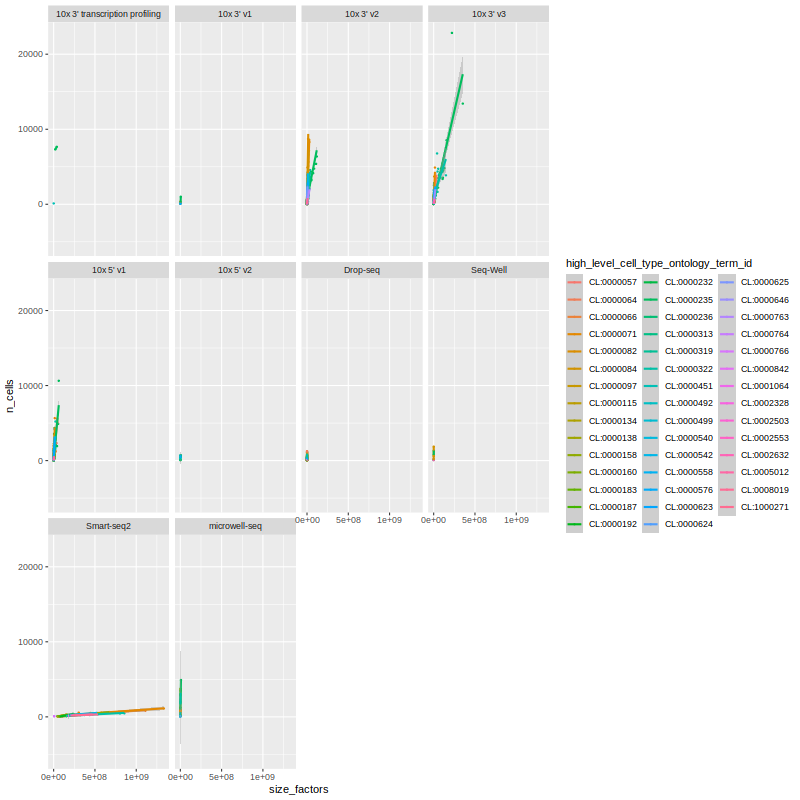

In [136]:
%%R -i size_factors_df -w 800  -h 800
size_factors_df %>%
    ggplot(aes(size_factors, n_cells, color=high_level_cell_type_ontology_term_id)) +
    geom_point(size=0.5) +
    geom_smooth(method='lm') +
    facet_wrap(assay~.)
    


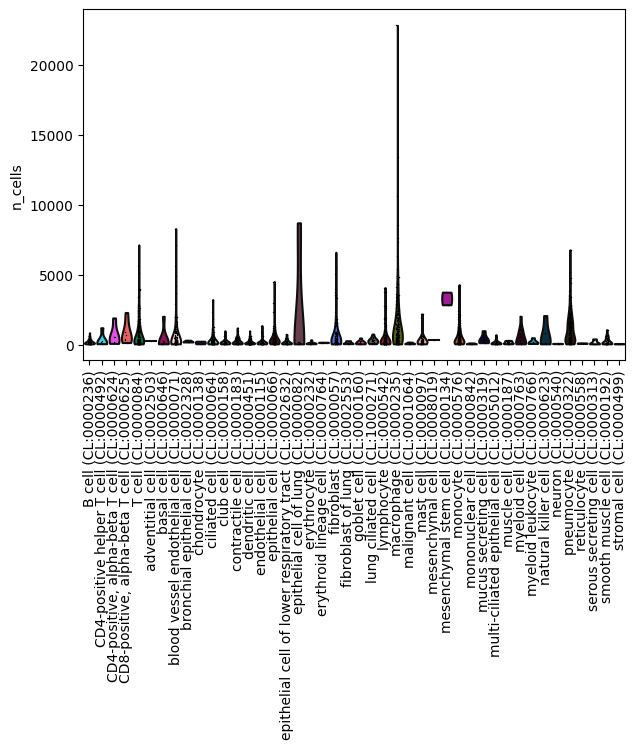

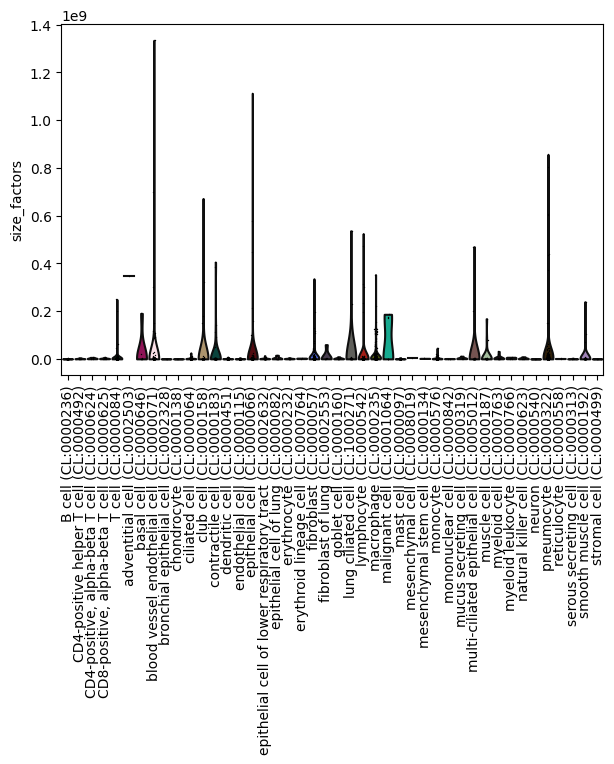

In [135]:
sc.pl.violin(pbulk_adata, 'n_cells', groupby='high_level_cell_type', rotation=90)
sc.pl.violin(pbulk_adata, 'size_factors', groupby='high_level_cell_type', rotation=90)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


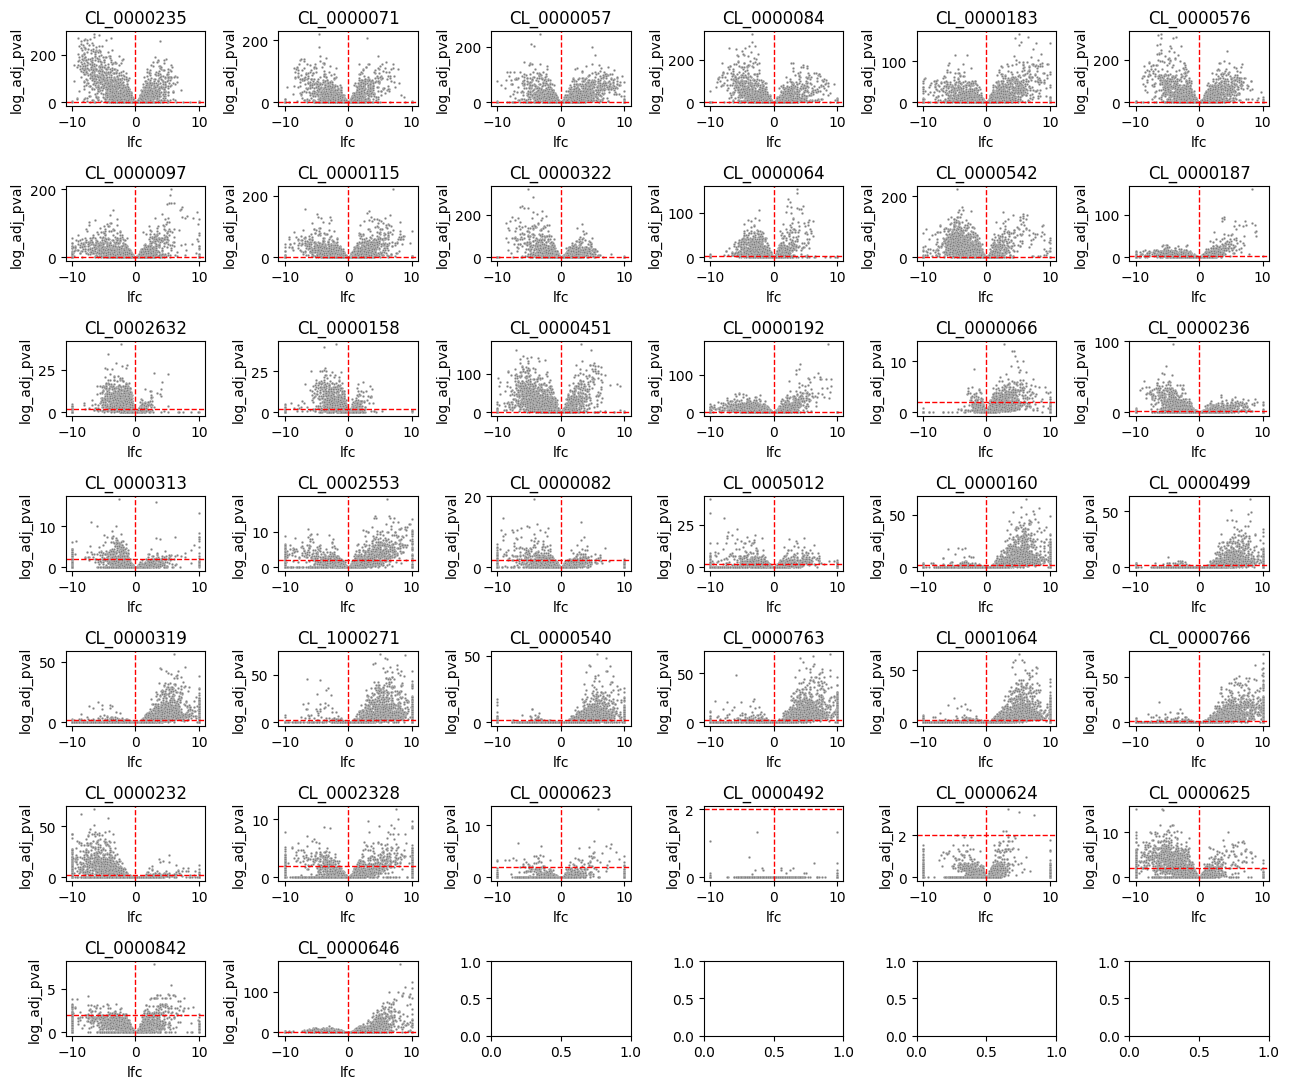

In [104]:
volcano_plot(disease_res, nrows=7, ncols=6, alpha=0.01)

In [80]:
pbulk_adata.layers['expr'] = pbulk_adata.X.copy()
pbulk_adata.layers['expr'][pbulk_adata.layers['expr'].nonzero()] = 1

In [494]:
pbulk_adata.var['mean_counts'] = np.array(pbulk_adata.X.mean(0)).flatten()
pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()
pbulk_adata.var['n_expressing'] = np.array(pbulk_adata.layers['expr'].sum(0)).flatten()

pbulk_adata.var = pd.concat([pbulk_adata.var, n_signif_cts.set_index('gene_id')], axis=1)

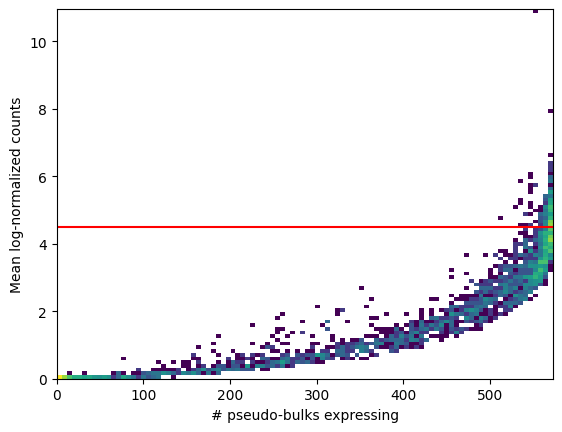

In [495]:
plt.hist2d(pbulk_adata.var['n_expressing'], pbulk_adata.var['mean_logcounts'], bins=100, norm=matplotlib.colors.LogNorm());
plt.xlabel('# pseudo-bulks expressing');
plt.ylabel('Mean log-normalized counts');
plt.axhline(pbulk_adata.var['mean_logcounts'].quantile(0.90), color='red')

In [496]:
# pbulk_adata.var = pbulk_adata.var.drop('n_signif_cts', 1)

In [438]:
offending_ids = pbulk_adata.var[pbulk_adata.var['n_expressing'] > 200].sort_values('n_expressing')['feature_name']

<Figure size 960x190 with 0 Axes>

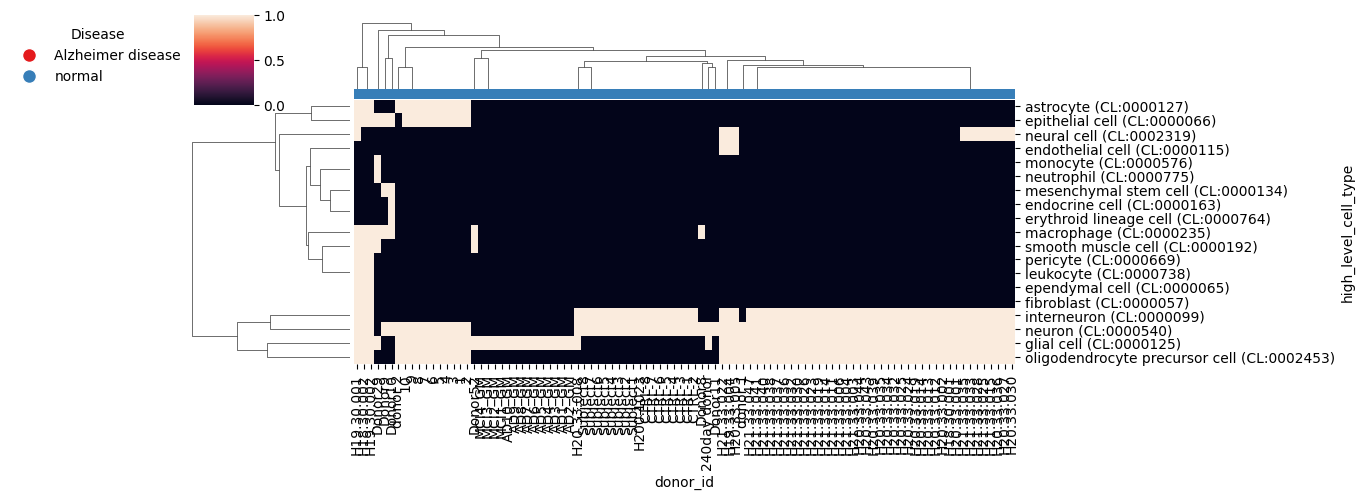

In [433]:
col_colors = [dict(zip(df['disease'].cat.categories, disease_palette))[x] for x in df['disease']]
df = pbulk_adata.obs.copy()
df['donor_id'] = df['donor_id'].astype('str')
conf_mat = sc.metrics.confusion_matrix('donor_id', 'high_level_cell_type', df, normalize=False)

disease_palette = sns.color_palette("Set1", n_colors=len(df['disease'].cat.categories))
disease_color_mapping = dict(zip(df['disease'].cat.categories, disease_palette))

fig_height, fig_width = (x /10 for x in conf_mat.shape)


plt.figure(figsize=(fig_height, fig_width))

# Clustermap for the confusion matrix
col_colors = [disease_color_mapping[x] for x in df['disease']]
clustermap = sns.clustermap(
    conf_mat.T, 
    figsize=(12, 5), 
    col_colors=col_colors,
    xticklabels=True,
    yticklabels=True
)
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat, markerfacecolor=disease_color_mapping[cat], markersize=10) for cat in df['disease'].cat.categories]
plt.legend(
    handles=legend_handles, 
    title='Disease', frameon=False, 
    loc='upper right', bbox_to_anchor=(0, 1.0))

plt.show()


In [138]:
sc_evidence = 'diseasecelltype'
disease_res = pd.read_csv(f'{data_dir}/DE_{sc_evidence}_{disease_ontology_id}.all_targets.csv')


In [149]:
[x for x in pbulk_adata.obs.high_level_cell_type.unique() in x]

[]

In [154]:
disease_res[disease_res['gene_name'] == 'CFTR']

gene_name      pval  adj_pval  f_statistic  df1         df2       lfc  \
1093      CFTR  0.041900  0.103570     4.229899    1  119.231967 -1.430148   
3597      CFTR  0.101769  0.175987     2.712765    1  141.393514 -1.023651   

     gene_name.1          gene_id high_level_cell_type_ontology_term_id  \
1093        CFTR  ENSG00000001626                            CL:0000064   
3597        CFTR  ENSG00000001626                            CL:0000066   

      confounder_warning  log_adj_pval  
1093                   2      0.984765  
3597                   2      0.754519

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


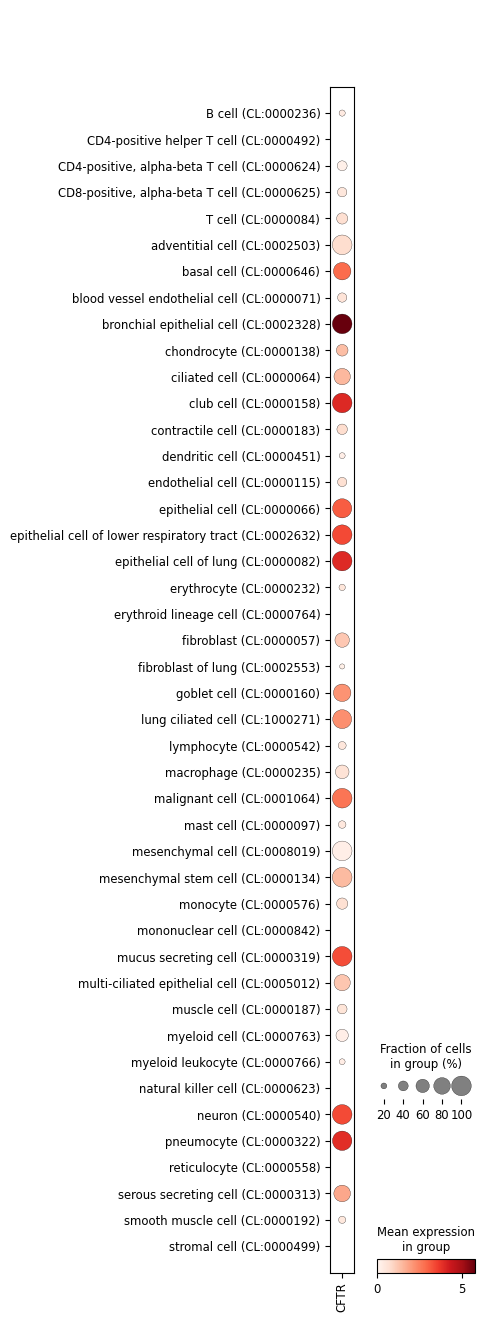

In [158]:
sc.pl.dotplot(pbulk_adata[pbulk_adata.obs['disease'] == 'normal'], 'CFTR',groupby='high_level_cell_type',layer='logcounts', gene_symbols='feature_name')

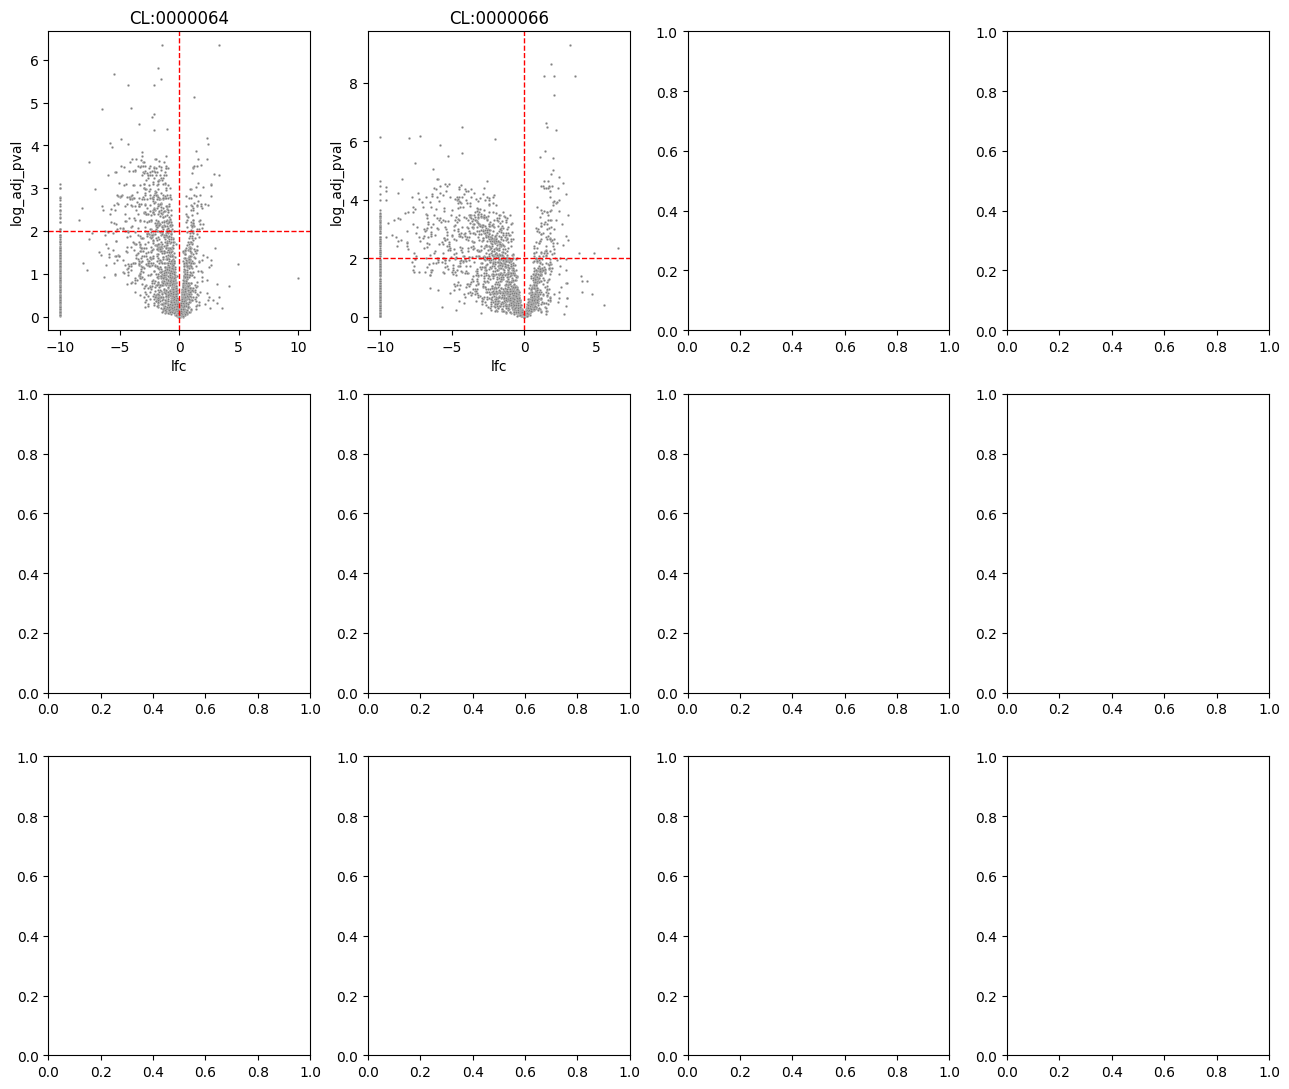

In [141]:
volcano_plot(disease_res, alpha=0.01)

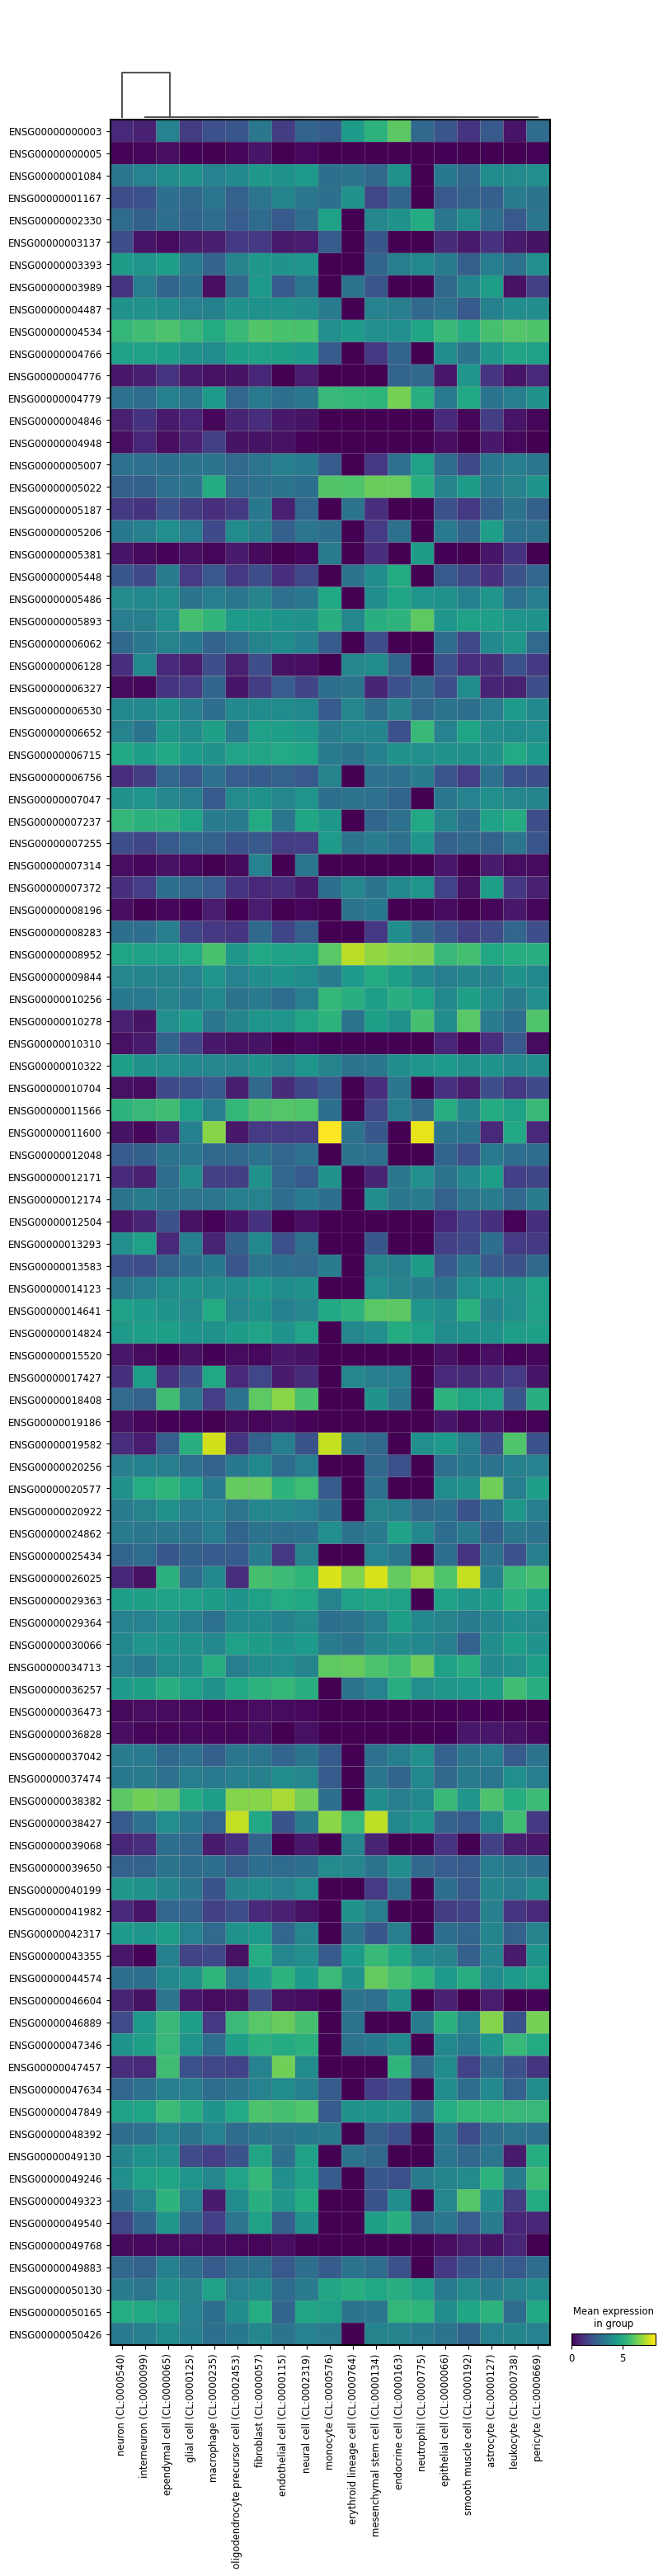

In [467]:
sc.pl.matrixplot(
            pbulk_adata, 
            n_signif_cts[n_signif_cts['n_signif_cts'] < 3].gene_id.values[0:100], 
            'high_level_cell_type', 
#             gene_symbols='feature_name', 
            dendrogram=True, 
#     standard_scale='var', 
    swap_axes=True,
            layer='logcounts')

# dpl.style(cmap='magma', edge_lw=0)
# dpl.legend(title =  'Mean\nlog-normalized\nexpression')
# _ = dpl.get_axes()['mainplot_ax'].set_xlabel(f'Target genes - ({disease_ontology_id})',fontsize=20)
plt.show()

## Test celltype model with and without intercept

In [9]:
disease_ontology_id = 'MONDO:0004994'

In [10]:
import scanpy as sc
from sc_target_evidence_utils import DE_utils, cellontology_utils

def clean_disease(pbulk_adata):
    '''Uniform disease naming.'''        
    DISEASE_RENAME = {'cardiomyopathy':[
        'arrhythmogenic right ventricular cardiomyopathy',
        'dilated cardiomyopathy',
        'non-compaction cardiomyopathy'],
    'renal cell carcinoma':['chromophobe renal cell carcinoma', 'clear cell renal carcinoma'],
    'colorectal cancer': ['colorectal cancer', 'colorectal neoplasm'],
        'non-small cell lung carcinoma':['lung large cell carcinoma', 'non-small cell lung carcinoma']
        }

    disease_rename_rev = {x:k for k,v in DISEASE_RENAME.items() for x in v }

    pbulk_adata.obs['disease_name_original'] = pbulk_adata.obs['disease'].copy()
    pbulk_adata.obs['disease'] = [disease_rename_rev[x] if x in disease_rename_rev.keys() else x for x in pbulk_adata.obs.disease]

# Load pseudobulk data
pbulk_adata = sc.read_h5ad(data_dir + f'cellxgene_targets_{disease_ontology_id.replace(":", "_")}.pbulk_all_OT_targets.h5ad')

# clean pseudobulk data
clean_disease(pbulk_adata)
graph = cellontology_utils.get_cellontology_graph(data_dir)
pbulk_adata = pbulk_adata[pbulk_adata.obs['high_level_cell_type_ontology_term_id'] != 'low_quality_annotation'].copy()
pbulk_adata.obs['high_level_cell_type'] = [f'{cellontology_utils.ontology2name(x, graph)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]
pbulk_adata.obs['disease_ontology_id'] = disease_ontology_id

# Exclude blacklisted assays
assay_blacklist = [
    'BD Rhapsody Targeted mRNA',
    'STRT-seq',
    'inDrop'
    ]

pbulk_adata = pbulk_adata[~pbulk_adata.obs['assay'].isin(assay_blacklist)].copy()

In [ ]:
# Run DE analysis
# ct_res_intercept = DE_utils.celltype_marker_targets(pbulk_adata, remove_intercept=False)
ct_res_nointercept = DE_utils.celltype_marker_targets(pbulk_adata, remove_intercept=True)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-en

In [ ]:
ct_res_intercept = DE_utils.celltype_marker_targets(pbulk_adata, remove_intercept=False)

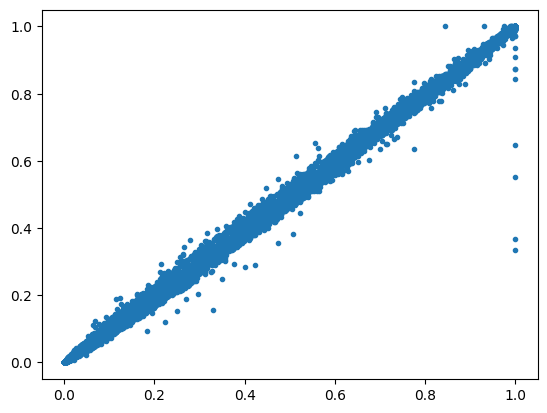

In [35]:
plt.plot(ct_res_intercept.adj_pval, ct_res_nointercept.adj_pval, '.');

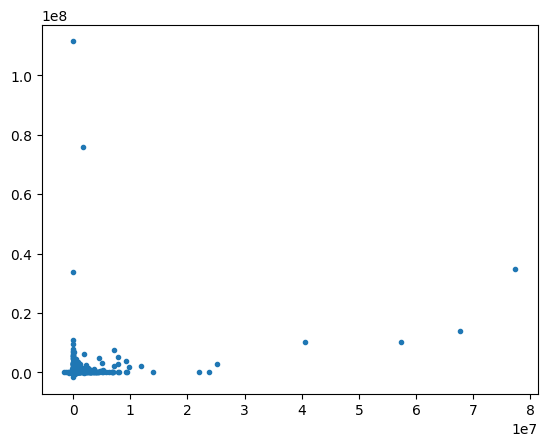

In [36]:
plt.plot(ct_res_intercept.lfc, ct_res_nointercept.lfc, '.');

In [37]:

## Preprocess expression
cpms = scipy.sparse.csr_matrix(pbulk_adata.X.T / pbulk_adata.obs['size_factors'].values.flatten()) * 1000000
pbulk_adata.layers['logcounts'] = np.log1p(cpms).T
pbulk_adata.obs['high_level_cell_type'] = [f'{ontology2name(x)} ({x})' for x in pbulk_adata.obs['high_level_cell_type_ontology_term_id'].tolist()]
pbulk_adata.obs['sample_id'] = ['-'.join(x[1:]) for x in pbulk_adata.obs_names.str.split("-")]

pbulk_adata.var['mean_logcounts'] = np.array(pbulk_adata.layers['logcounts'].mean(0)).flatten()

/tmp/ipykernel_1741/666901491.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_1741/666901491.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_1741/666901491.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.su

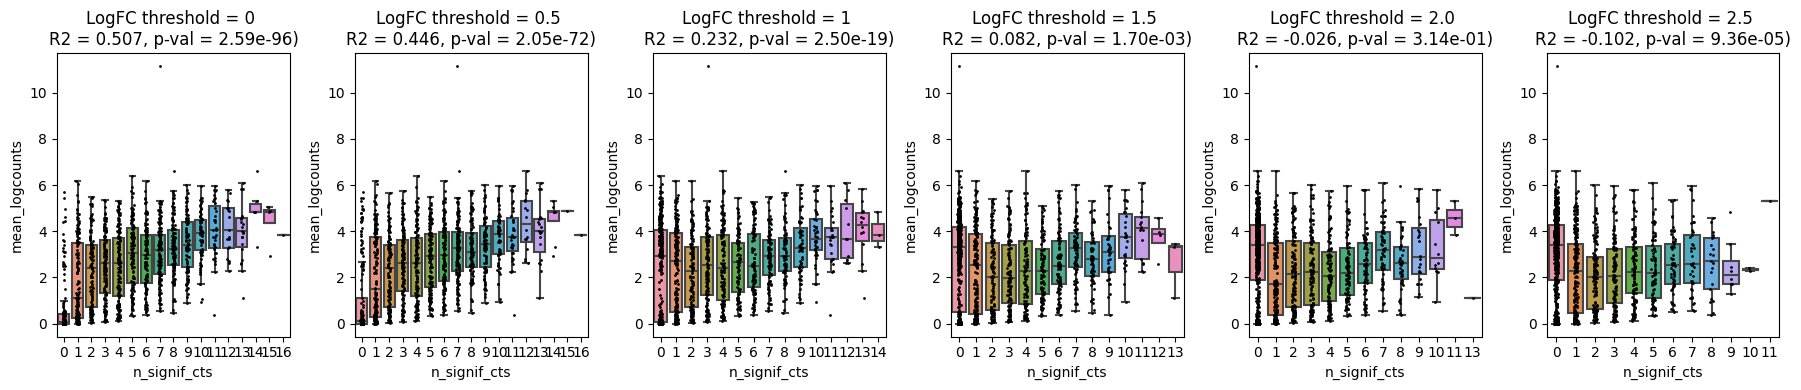

In [39]:
signif_thresh = 0.1

lfcs = [0, 0.5, 1, 1.5, 2.0, 2.5]
sc_evidence='celltype'
disease_res = ct_res_intercept.copy()
with plt.rc_context({'figure.figsize':[18,4]}):
    for i,lfc_thresh in enumerate(lfcs):
        n_cell_types = disease_res.high_level_cell_type_ontology_term_id.nunique()
        if sc_evidence == 'diseasecelltype':
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & (np.abs(disease_res['lfc']) > lfc_thresh)
        else:
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & ((disease_res['lfc']) > lfc_thresh)

        n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
        n_signif_cts = n_signif_cts.reset_index()
        n_signif_cts.columns = ['gene_id', 'n_signif_cts']
    #     disease_res = pd.merge(disease_res, n_signif_cts)
        pbulk_adata.var['n_signif_cts'] = n_signif_cts.set_index('gene_id').loc[pbulk_adata.var_names]

        plt.subplot(1,len(lfcs),i+1)
        sns.boxplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', sym='')
        sns.stripplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', size=2, color='black')
        r2, pval = scipy.stats.pearsonr(pbulk_adata.var['mean_logcounts'], pbulk_adata.var['n_signif_cts'])
        plt.title(f"LogFC threshold = {lfc_thresh} \nR2 = {np.round(r2, 3)}, p-val = {pval:.2e})")
        
plt.tight_layout()

/tmp/ipykernel_1741/2356778587.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_1741/2356778587.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
/tmp/ipykernel_1741/2356778587.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy

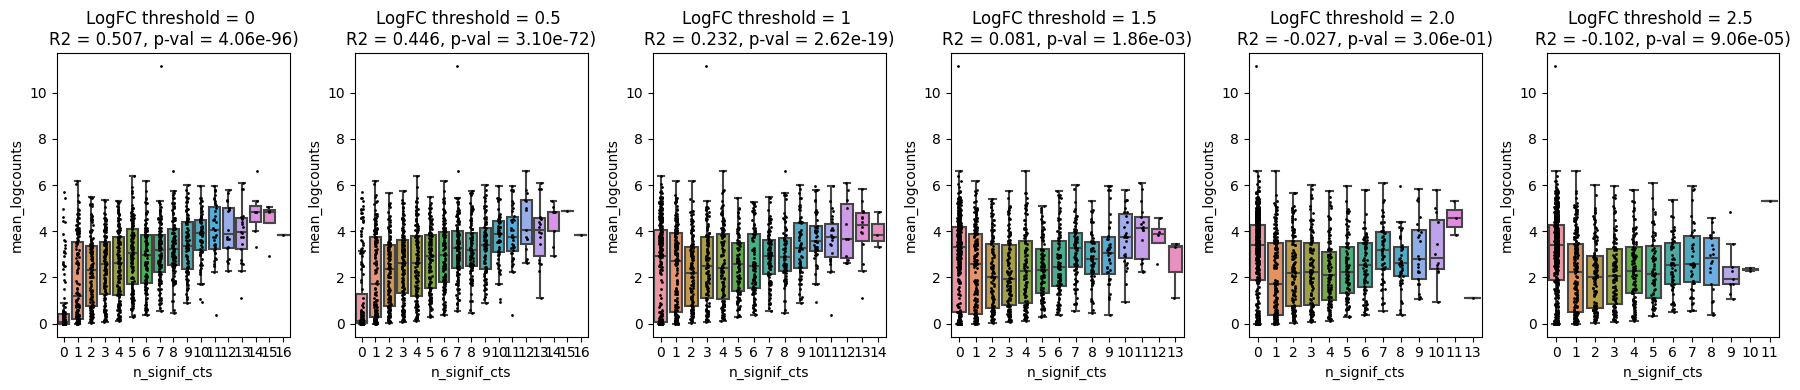

In [40]:
signif_thresh = 0.1

lfcs = [0, 0.5, 1, 1.5, 2.0, 2.5]
sc_evidence='celltype'
disease_res = ct_res_nointercept.copy()
with plt.rc_context({'figure.figsize':[18,4]}):
    for i,lfc_thresh in enumerate(lfcs):
        n_cell_types = disease_res.high_level_cell_type_ontology_term_id.nunique()
        if sc_evidence == 'diseasecelltype':
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & (np.abs(disease_res['lfc']) > lfc_thresh)
        else:
            disease_res['is_signif'] = (disease_res['adj_pval'] < signif_thresh) & ((disease_res['lfc']) > lfc_thresh)

        n_signif_cts = disease_res.groupby(['gene_id', 'high_level_cell_type_ontology_term_id']).sum()['is_signif'].reset_index().groupby('gene_id')['is_signif'].sum('is_signif')
        n_signif_cts = n_signif_cts.reset_index()
        n_signif_cts.columns = ['gene_id', 'n_signif_cts']
    #     disease_res = pd.merge(disease_res, n_signif_cts)
        pbulk_adata.var['n_signif_cts'] = n_signif_cts.set_index('gene_id').loc[pbulk_adata.var_names]

        plt.subplot(1,len(lfcs),i+1)
        sns.boxplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', sym='')
        sns.stripplot(data=pbulk_adata.var, x='n_signif_cts', y='mean_logcounts', size=2, color='black')
        r2, pval = scipy.stats.pearsonr(pbulk_adata.var['mean_logcounts'], pbulk_adata.var['n_signif_cts'])
        plt.title(f"LogFC threshold = {lfc_thresh} \nR2 = {np.round(r2, 3)}, p-val = {pval:.2e})")
        
plt.tight_layout()

IndexError: index 5 is out of bounds for axis 0 with size 5

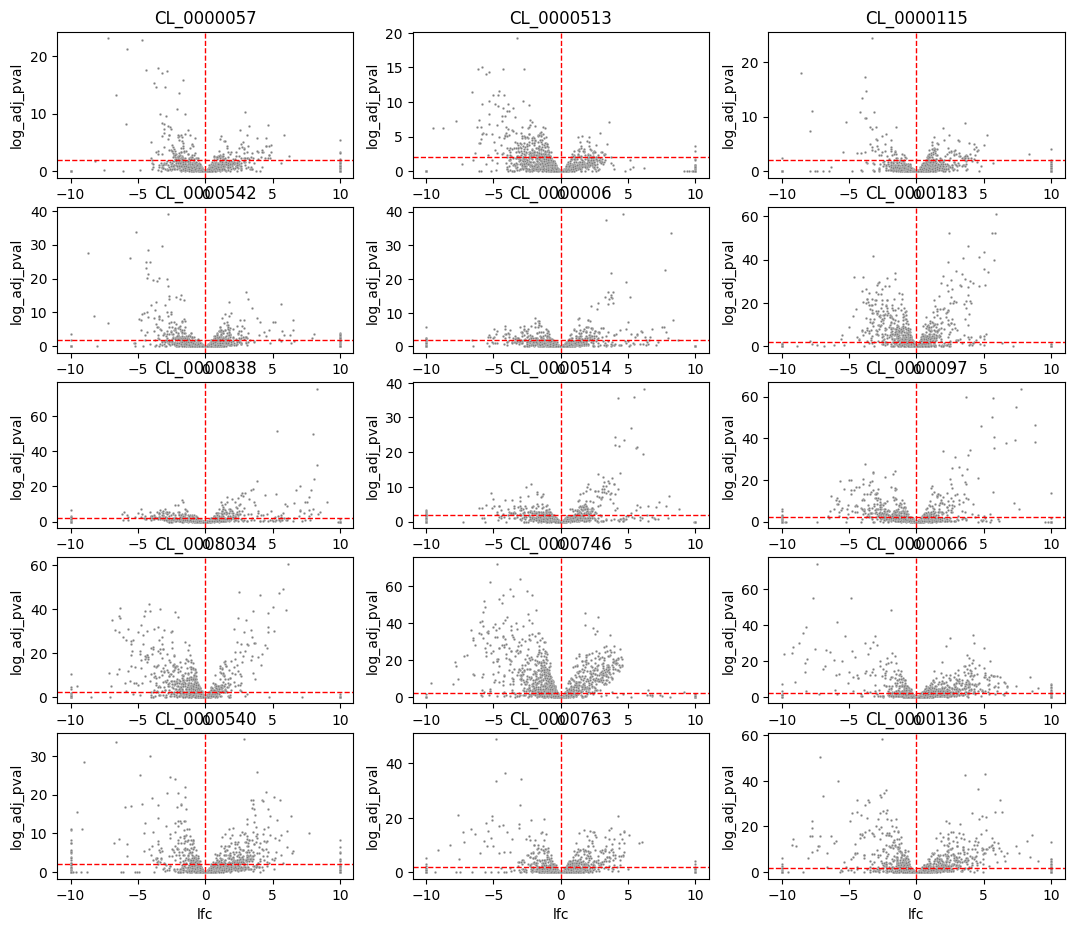

In [76]:
volcano_plot(ct_res_intercept, ncols=3, nrows=5, alpha=0.01)
plt.tight_layout()

IndexError: index 3 is out of bounds for axis 0 with size 3

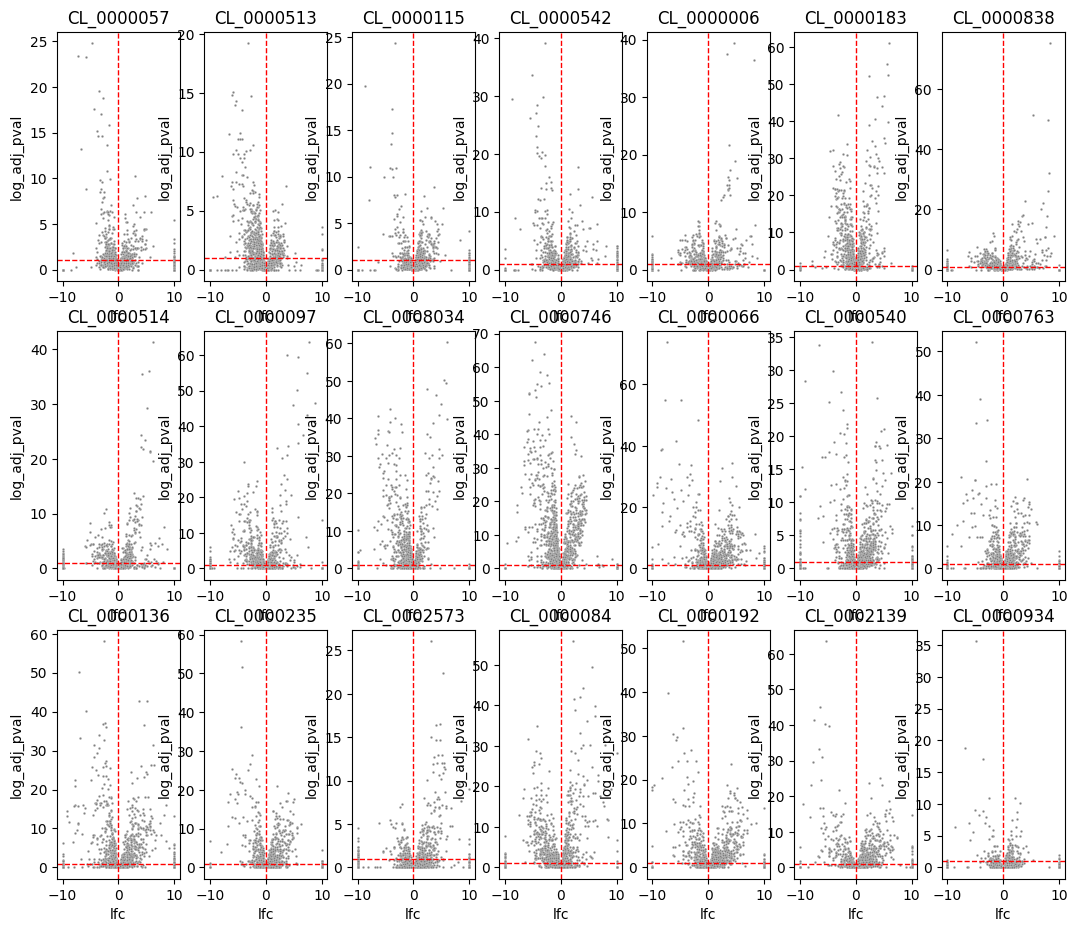

In [51]:
volcano_plot(ct_res_nointercept, ncols=7)

In [57]:
df = pbulk_adata.var[['mean_logcounts', 'feature_id']].copy()
df.columns = ['mean_logcounts', 'gene_id']
ct_res_nointercept = pd.merge(ct_res_nointercept, df)

In [65]:
ct_res_nointercept

pval  adj_pval   f_statistic  df1         df2           lfc  \
0      0.040161  0.128762  4.238787e+00    1  397.837336 -2.015794e+00   
1      0.120609  0.236686  2.419747e+00    1  397.830749 -1.865975e+00   
2      0.898641  0.999097  1.624601e-02    1  397.833601 -1.294610e-01   
3      0.448865  0.660867  5.746512e-01    1  397.835133 -7.631536e-01   
4      0.888989  0.977955  1.950856e-02    1  397.832388  1.353275e-01   
...         ...       ...           ...  ...         ...           ...   
42393  1.000000  1.000000 -4.553810e-07    1  397.835229  9.491735e-22   
42394  0.999903  1.000000  1.473773e-08    1  397.835469 -1.408533e-21   
42395  1.000000  1.000000 -6.852488e-04    1  397.837314  1.000000e+01   
42396  1.000000  1.000000 -3.844295e-03    1  397.838367 -1.000000e+01   
42397  1.000000  1.000000 -2.591491e-08    1  397.830802 -1.405795e+00   

      gene_name          gene_id high_level_cell_type_ontology_term_id  \
0         ISG15  ENSG00000187608                            CL_0000057   
1         ISG15  ENSG00000187608                            CL_0000513   
2         ISG15  ENSG00000187608                            CL_0000115   
3         ISG15  ENSG00000187608                            CL_0000542   
4         ISG15  ENSG00000187608                            CL_0000006   
...         ...              ...                                   ...   
42393    PKD1L2  ENSG00000166473                            CL_0000576   
42394    PKD1L2  ENSG00000166473                            CL_0000236   
42395    PKD1L2  ENSG00000166473                            CL_0000451   
42396    PKD1L2  ENSG00000166473                            CL_0000896   
42397    PKD1L2  ENSG00000166473                            CL_0000499   

       log_adj_pval  mean_logcounts  
0          0.890214        2.490794  
1          0.625828        2.490794  
2          0.000392        2.490794  
3          0.179886        2.490794  
4          0.009681        2.490794  
...             ...             ...  
42393     -0.000000        0.002968  
42394     -0.000000        0.002968  
42395     -0.000000        0.002968  
42396     -0.000000        0.002968  
42397     -0.000000        0.002968  

[42398 rows x 11 columns]

In [64]:
for ct in ct_res_nointercept.high_level_cell_type_ontology_term_id.unique():
    print(ct_res_nointercept[ct_res_nointercept.high_level_cell_type_ontology_term_id == ct ].corr().loc['mean_logcounts', 'lfc'])

-0.38803083712362146
-0.19012443431943707
-0.29161987375741727
-0.2236766860500469
0.3618674120554391
0.10399017346619988
0.3468371413723062
0.3757091489349763
0.2810875916518066
0.27911587879940347
0.007921279692667057
-0.27536352927849356
0.05153748717260038
-0.06845219270261421
-0.14987488280814187
-0.3285113584433837
0.27643987067406584
0.2241671913008493
-0.21470600922084135
-0.2617998628374988
-0.01511429705249612
-0.05982612233839365
-0.01697458576593363
-0.04823009417321605
-0.16189544618678886
-0.018538034948246036
0.15231174695036168
0.2458389275208329
0.08883675041275173


/tmp/ipykernel_1741/1604597151.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(ct_res_nointercept[ct_res_nointercept.high_level_cell_type_ontology_term_id == ct ].corr().loc['mean_logcounts', 'lfc'])


In [59]:
sns.scatterplot(x=ct_res_nointercept.mean_logcounts, 
                y=ct_res_nointercept.lfc, 
                hue=ct_res_intercept.high_level_cell_type_ontology_term_id,
                size=1)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/seaborn/_oldcore.py:962: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  plot_data = pd.DataFrame(plot_data)


ValueError: cannot reindex on an axis with duplicate labels